<a href="https://colab.research.google.com/github/Exabyte-io/api-examples/blob/dev/examples/workflow/qe_scf_calculation.ipynb" target="_parent">
<img alt="Open in Google Colab" src="https://user-images.githubusercontent.com/20477508/128780728-491fea90-9b23-495f-a091-11681150db37.jpeg" width="150" border="0">
</a>

# Quantum Espresso SCF calculation via API


# Complete Authorization Form and Initialize Settings

This will also determine environment and set all environment variables. We determine if we are using Jupyter Notebooks or Google Colab to run this tutorial.

If you are running this notebook from Google Colab, Colab takes ~1 min to execute the following cell.

ACCOUNT_ID and AUTH_TOKEN - Authentication parameters needed for when making requests to [Mat3ra.com's API Endpoints](https://docs.mat3ra.com/rest-api/endpoints/).

MATERIALS_PROJECT_API_KEY - Authentication parameter needed for when making requests to [Material Project's API](https://materialsproject.org/open)

ORGANIZATION_ID - Authentication parameter needed for when working with collaborative accounts https://docs.mat3ra.com/collaboration/organizations/overview/

> <span style="color: orange">**NOTE**</span>: If you are running this notebook from Jupyter, the variables ACCOUNT_ID, AUTH_TOKEN, MATERIALS_PROJECT_API_KEY, and ORGANIZATION_ID should be set in the file [settings.json](../../utils/settings.json) if you need to use these variables. To obtain API token parameters, please see the following link to the documentation explaining how to get them: https://docs.mat3ra.com/accounts/ui/preferences/api/

In [1]:
# @title Authorization Form
ACCOUNT_ID = "ACCOUNT_ID"  # @param {type:"string"}
AUTH_TOKEN = "AUTH_TOKEN"  # @param {type:"string"}
MATERIALS_PROJECT_API_KEY = "MATERIALS_PROJECT_API_KEY"  # @param {type:"string"}
ORGANIZATION_ID = "ORGANIZATION_ID"  # @param {type:"string"}

import os

if "COLAB_JUPYTER_IP" in os.environ:
    os.environ.update(
        dict(
            ACCOUNT_ID=ACCOUNT_ID,
            AUTH_TOKEN=AUTH_TOKEN,
            MATERIALS_PROJECT_API_KEY=MATERIALS_PROJECT_API_KEY,
            ORGANIZATION_ID=ORGANIZATION_ID,
        )
    )

    !GIT_BRANCH="dev"; export GIT_BRANCH; curl -s "https://raw.githubusercontent.com/Exabyte-io/api-examples/${GIT_BRANCH}/scripts/env.sh" | bash

In [2]:
from utils.settings import ENDPOINT_ARGS, ACCOUNT_ID
from utils.generic import wait_for_jobs_to_finish

from exabyte_api_client.endpoints.workflows import WorkflowEndpoints
from exabyte_api_client.endpoints.materials import MaterialEndpoints
from exabyte_api_client.endpoints.jobs import JobEndpoints

In [3]:
# Initialize a helper class to interact with WorkflowEndpoints
workflow_endpoints = WorkflowEndpoints(*ENDPOINT_ARGS)
material_endpoints = MaterialEndpoints(*ENDPOINT_ARGS)
job_endpoints = JobEndpoints(*ENDPOINT_ARGS)

#### Create a Quantum Espresso workflow for SCF calculation

Below we provide our Quantum Espresso input file via a bash script.

Note that we provide the pseudo potential file via a downloadable url. We are working on suppporting uploading pseudo potential file from local file system, but it is currently not available.

In [4]:
# user modifiable part
script = r"""#!/bin/bash

# switch to the job working directory
cd $PBS_O_WORKDIR

# ----------------------- QUANTUM ESPRESSO INPUT FILE ------------------------ #
cat > pw.in << EOF
&CONTROL
  calculation = 'scf',
  prefix = 'silicon',
  outdir = './tmp/'
  pseudo_dir = './'
/

&SYSTEM
  ibrav =  2,
  celldm(1) = 10.26,
  nat =  2,
  ntyp = 1,
  ecutwfc = 30
  nbnd = 8
/

&ELECTRONS
  conv_thr = 1e-8,
  mixing_beta = 0.6
/

ATOMIC_SPECIES
  Si 28.086 Si.pz-vbc.UPF

ATOMIC_POSITIONS (alat)
  Si 0.0 0.0 0.0
  Si 0.25 0.25 0.25

K_POINTS (automatic)
  7 7 7 0 0 0
EOF
# -------------------------- PSEUDO POTENTIAL FILE --------------------------- #
# provide a downloadable link for the pseudo potential file
wget https://raw.githubusercontent.com/pranabdas/espresso/main/src/pseudos/Si.pz-vbc.UPF
# --------------------------------- RUN JOB ---------------------------------- #
# load required module
module add espresso/63-i-174-impi-044

mpirun -np $PBS_NP pw.x -in pw.in | tee pw.out
"""

In [5]:
# populate workflow from a template
import json

with open("../assets/bash_workflow_template.json", "r") as f:
    WORKFLOW_BODY = json.load(f)

WORKFLOW_BODY["subworkflows"][0]["units"][0]["input"][0]["content"] = script

In [6]:
# create workflow
WORKFLOW_RESP = workflow_endpoints.create(WORKFLOW_BODY)

### Create and submit job

Below user can specify the project name and compute parameters such as `queue`, number of `nodes` and number of processors `ppn` per node. Find more about compute parameters [here](https://docs.mat3ra.com/infrastructure/compute/parameters/).

In [7]:
# job creation payload
JOB_BODY = {
    "name": "SCF Calculation",
    "compute": {
        "ppn": 4,
        "nodes": 1,
        "queue": "OR",
        "cluster": {"fqdn": "master-production-20160630-cluster-001.exabyte.io"},
    },
    "_project": {"slug": "pranab-default"},
    "workflow": WORKFLOW_RESP["_id"],
}

In [8]:
# create job
JOB_RESP = job_endpoints.create(JOB_BODY)

In [ ]:
# TODO: NOT SUPPORTED YET, upload pseudo potential file
# with open('../assets/Si.pz-vbc.UPF', 'r') as f:
#     PP_FILE = f.read()
#     data = json.dumps({"files": PP_FILE})
#     FILE_RESP=job_endpoints.insert_output_files(JOB_RESP["_id"], data)

In [9]:
# submit job to run
job_endpoints.submit(JOB_RESP["_id"])

In [ ]:
# monitor job and wait for it to be finished
wait_for_jobs_to_finish(job_endpoints, [JOB_RESP["_id"]], 30)

#### Get output file, perform post processing, and make plots

In [ ]:
files = job_endpoints.list_files(JOB_RESP["_id"])
for file in files:
    if file["name"] == "pw.out":
        output_file_metadata = file

import urllib

server_response = urllib.request.urlopen(output_file_metadata["signedUrl"])
output_file_bytes = server_response.read()
output_file = output_file_bytes.decode(encoding="UTF-8")

In [12]:
energy = []
len_energy = len("total energy")
for line in output_file.split("\n"):
    if line.strip().lstrip("!")[:len_energy] == "total energy":
        energy.append(float(line.split("=")[1].rstrip("Ry")))

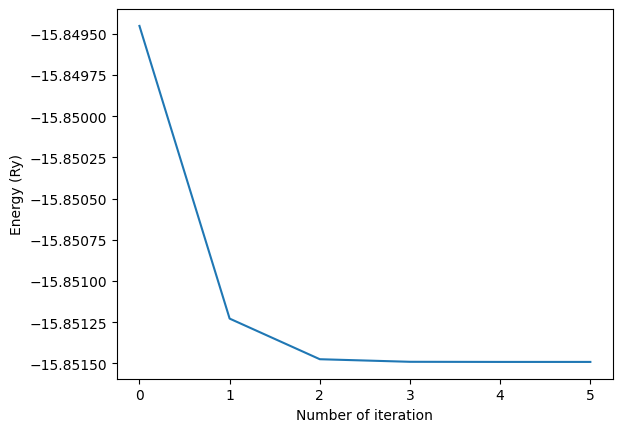

In [13]:
# plot energy with iteration step
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(energy)
plt.xlabel("Number of iteration")
plt.ylabel("Energy (Ry)")
plt.show()